In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Leemos los datos

In [2]:
ride_data = pd.read_csv('train_set.csv')

/Users/adiv/opt/anaconda3/envs/dsfs/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (8) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
ride_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 700000 entries, 0 to 699999
Data columns (total 14 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   trip_id              700000 non-null  int64  
 1   duration             700000 non-null  int64  
 2   start_time           700000 non-null  object 
 3   end_time             700000 non-null  object 
 4   start_lat            694437 non-null  float64
 5   start_lon            694437 non-null  float64
 6   end_lat              681426 non-null  float64
 7   end_lon              681426 non-null  float64
 8   bike_id              700000 non-null  object 
 9   plan_duration        699792 non-null  float64
 10  trip_route_category  700000 non-null  object 
 11  passholder_type      697424 non-null  object 
 12  start_station        700000 non-null  int64  
 13  end_station          700000 non-null  int64  
dtypes: float64(5), int64(4), object(5)
memory usage: 74.8+ MB


¿Cuantos tipos de passholder hay?

In [4]:
ride_data['passholder_type'].value_counts()

Monthly Pass    394769
Walk-up         212426
One Day Pass     44455
Annual Pass      34092
Flex Pass        11604
Testing             78
Name: passholder_type, dtype: int64

Exploremos los datos de las estaciones 

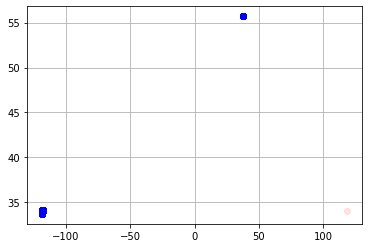

In [5]:
#Datos de ubicación de estaciones
plt.scatter(ride_data['start_lon'], ride_data['start_lat'], color='red', alpha=0.1)
plt.scatter(ride_data['end_lon'], ride_data['end_lat'], color='blue', alpha=0.1)
plt.grid(True)
plt.show()

Dado que el servicio de bicicletas es en Los Ángeles, los puntos en otras latitudes y longitudes probablemente sean errores en los datos. Veámos como se ven los puntos si nos acercamos a la posición de Los Ángeles 34.0522° N, 118.2437° W

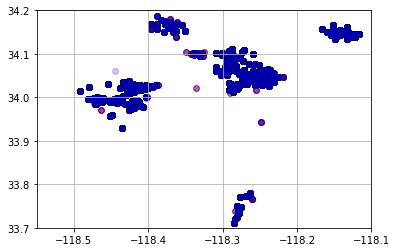

In [6]:
plt.scatter(ride_data['start_lon'], ride_data['start_lat'], color='red', alpha=0.01)
plt.scatter(ride_data['end_lon'], ride_data['end_lat'], color='blue', alpha=0.01)
plt.xlim(-118.55, -118.1)
plt.ylim(33.7,34.20)
plt.grid(True)
plt.show()

Con esto podemos descartar los datos que estén fuera de esta area

In [7]:
#Quitemos todas las filas de todas las columnas que contengan coordenadas incorrectas
ride_data.drop(ride_data[ride_data['start_lon'] > -100].index, inplace = True)
ride_data.drop(ride_data[ride_data['end_lon'] > -100].index, inplace = True)
ride_data.drop(ride_data[ride_data['start_lat'] > 35].index, inplace = True)
ride_data.drop(ride_data[ride_data['end_lat'] > 35].index, inplace = True)

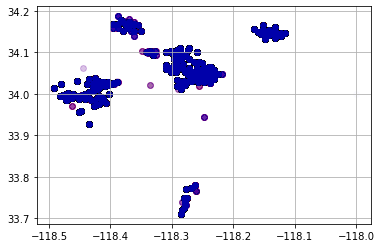

In [8]:
plt.scatter(ride_data['start_lon'], ride_data['start_lat'], color='red', alpha=0.01)
plt.scatter(ride_data['end_lon'], ride_data['end_lat'], color='blue', alpha=0.01)
plt.grid(True)
plt.show()

Veamos estos datos sobre un mapa de Los Angeles

In [9]:
import folium
import json
from folium import plugins

El archivo laMap.geojson fue obtenido en
https://github.com/ritvikmath/StarbucksStoreScraping/blob/master/laMap.geojson

In [10]:
with open('laMap.geojson') as f:
    laArea = json.load(f)

In [11]:
loc_data=ride_data[['start_lat','start_lon','end_lat','end_lon']] 
#se remueven los datos NaN
loc_data = loc_data.dropna(subset = ['start_lat','start_lon','end_lat','end_lon'])

Ya que solo quiero visualizar la ubicación geográfica de las estaciones, no necesito todo el dataset, entonces tomo una muestra.

In [12]:
loc_data = loc_data.head(50000) #aquí tal vez lo mejor era hacer un "unique" y luego "sort"

In [13]:
laMap = folium.Map(location=[34.0522,-118.2437], tiles='Stamen Toner', zoom_start=9)
folium.GeoJson(laArea).add_to(laMap)

for i,row in loc_data.iterrows():
    folium.CircleMarker((row.start_lat,row.start_lon), radius=3, weight=2, color='red', fill_color='red', fill_opacity=.5).add_to(laMap)

laMap.save('laPointMap.html')

El mapa obtenido se salva a un mapa interactivo de donde se pueden obtener imágenes (ver reporte en pdf)

Veámos cuales son las estaciones más utilizadas

In [14]:
most_used = ride_data.groupby(['start_lat', 'start_lon'])['start_lon'].count().reset_index(
  name='Count').sort_values(['Count'], ascending=False)

In [15]:
most_used = most_used.head(10)

In [16]:
most_used

,start_lat,start_lon,Count
243,34.048500,-118.258537,26393
269,34.051941,-118.243530,20280
67,33.995560,-118.481552,18540
284,34.056610,-118.237213,17783
37,33.984341,-118.471550,17179
211,34.044701,-118.252441,16175
241,34.048401,-118.260948,14647
95,34.014309,-118.491341,12812
226,34.046520,-118.237411,12720
219,34.045540,-118.256668,12009


Pasemos estos datos al mapa y veamos que sale (imagen en el archivo PDF)

In [17]:
laMap = folium.Map(location=[34.0522,-118.2437], tiles='Stamen Toner', zoom_start=9)
folium.GeoJson(laArea).add_to(laMap)

for i,row in most_used.iterrows():
    folium.CircleMarker((row.start_lat,row.start_lon), radius=5, weight=2, color='red', fill_color='red', fill_opacity=1).add_to(laMap)

laMap.save('laPointMap_mostUsed.html')

Para explorar el comportamiento de los datos a lo largo del tiempo, hay que cambiar las entradas en las columnas de "start_time" y "end_time" a objetos datetime

In [18]:
from datetime import datetime
import dateutil.parser

In [19]:
ride_data['start_time'] = ride_data['start_time'].apply(dateutil.parser.parse)
ride_data['end_time'] = ride_data['end_time'].apply(dateutil.parser.parse)

In [20]:
import matplotlib.dates as mdates

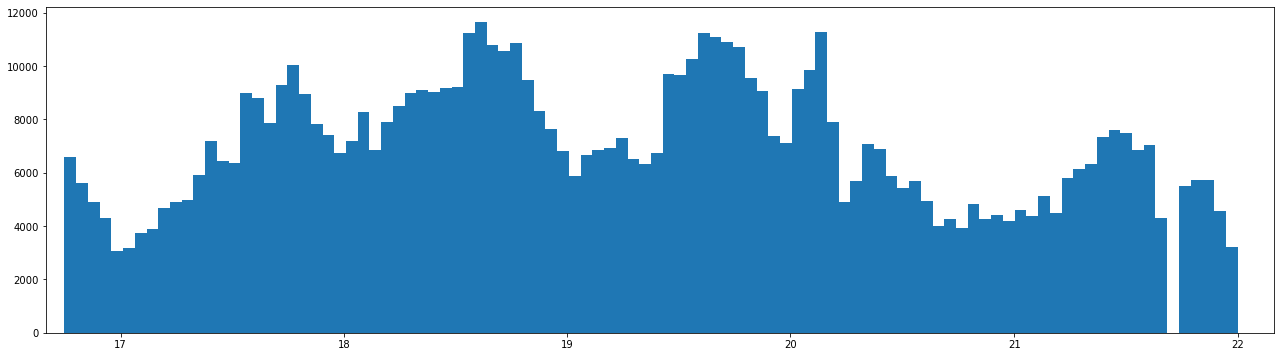

In [21]:
plt_date = mdates.date2num(ride_data['start_time'])
fig, ax = plt.subplots(1, figsize=(22,6))
n, bins, patches = plt.hist(plt_date, bins=100)
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%y'))
plt.xlim(mdates.datestr2num(['2016/09/01','2022/03/01']))
plt.show()

Del plot anteriores se puede ver que:
- Hay un efecto estacional, es decir, hay una subida en la demanda del servicio hacia la segunda mitad del año (verano e inicio de otoño) y una caida hacia el invierno.
- En el año 2020 hubo una caida súbita en el servicio que coincide con las restricciones debido a la pandemia de covid
- Para el 2021 pareciera haber una recuperación estacional en el verano con una caida hacia el inverno.
- El hueco en la segunda mitad del 2021 probablemente se debe a una interrupción en la adquisión de datos.

Veamos como se distribuyen a lo largo del tiempo el "start_time" a lo largo del tiempo para cada categoría del "passholder_type"

In [22]:
ride_data['passholder_type'].value_counts()

Monthly Pass    394750
Walk-up         212322
One Day Pass     44412
Annual Pass      34059
Flex Pass        11604
Testing             78
Name: passholder_type, dtype: int64

In [23]:
ride_data_Monthly = ride_data.loc[ride_data['passholder_type'] == 'Monthly Pass']

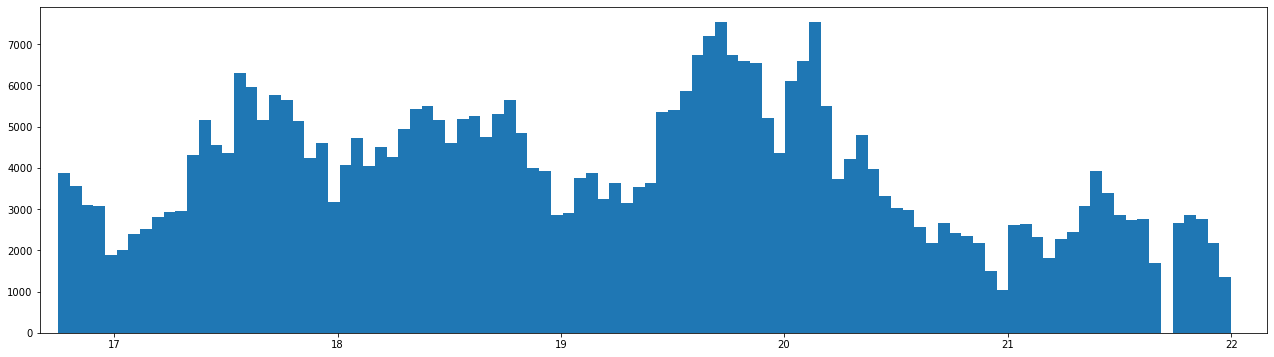

In [24]:
plt_date = mdates.date2num(ride_data_Monthly['start_time'])
fig, ax = plt.subplots(1, figsize=(22,6))
n, bins, patches = plt.hist(plt_date, bins=100)
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%y'))
plt.xlim(mdates.datestr2num(['2016/09/01','2022/03/01']))
plt.show()

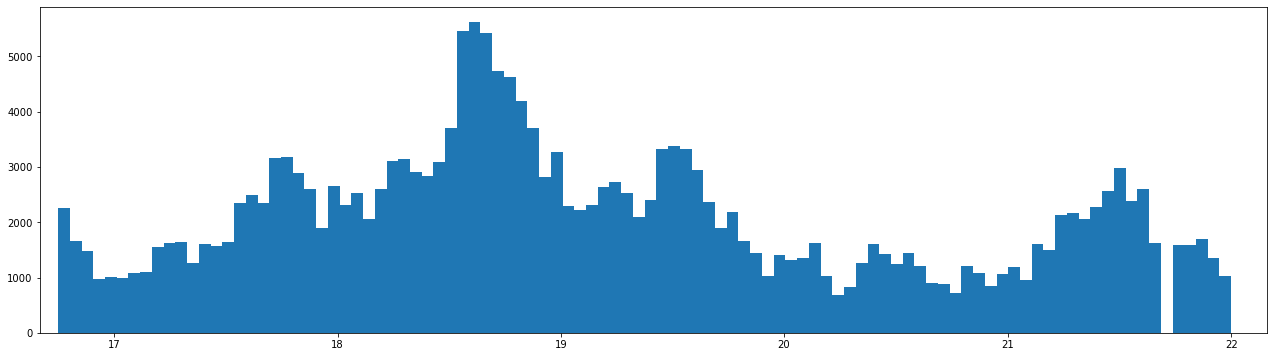

In [25]:
ride_data_Walk = ride_data.loc[ride_data['passholder_type'] == 'Walk-up']
plt_date = mdates.date2num(ride_data_Walk['start_time'])
fig, ax = plt.subplots(1, figsize=(22,6))
n, bins, patches = plt.hist(plt_date, bins=100)
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%y'))
plt.xlim(mdates.datestr2num(['2016/09/01','2022/03/01']))
plt.show()

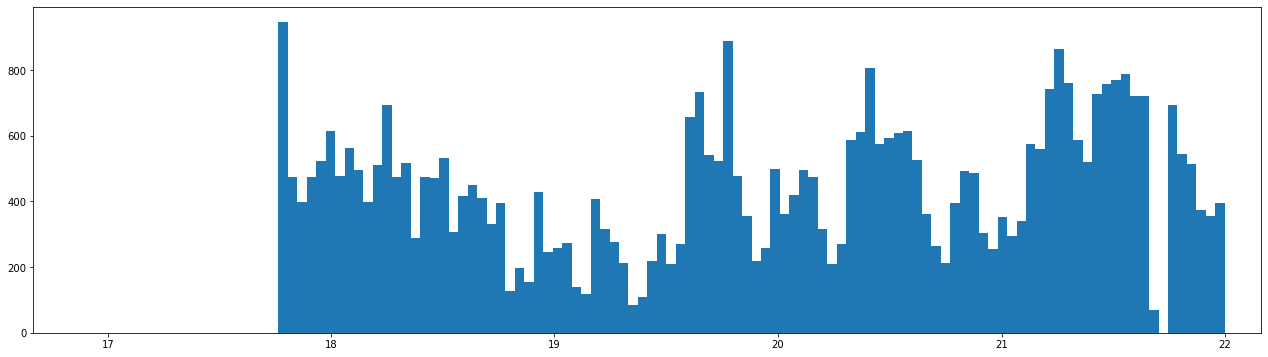

In [26]:
ride_data_One_Day = ride_data.loc[ride_data['passholder_type'] == 'One Day Pass']
plt_date = mdates.date2num(ride_data_One_Day['start_time'])
fig, ax = plt.subplots(1, figsize=(22,6))
n, bins, patches = plt.hist(plt_date, bins=100)
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%y'))
plt.xlim(mdates.datestr2num(['2016/09/01','2022/03/01']))
plt.show()

Aquí pareciera que hubo un corte en los datos del "One Day Pass" o tal opción no existía y tuvo una súbida demanda.

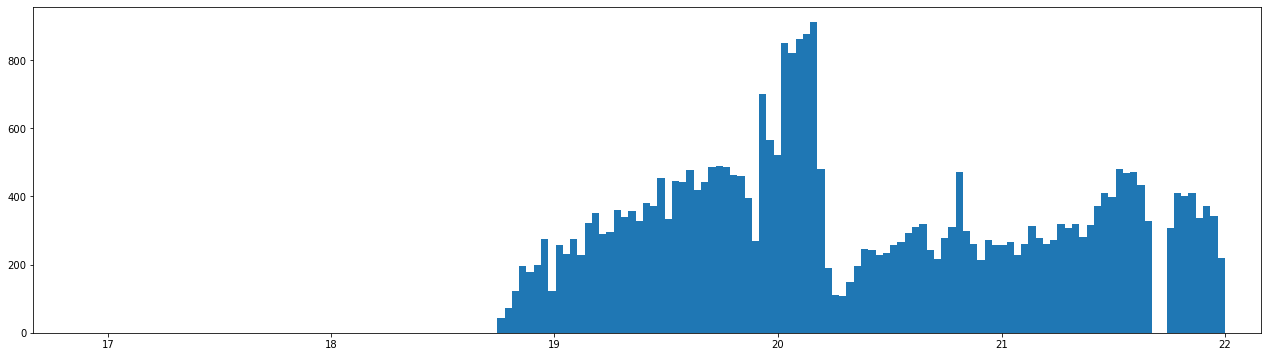

In [27]:
ride_data_Annual = ride_data.loc[ride_data['passholder_type'] == 'Annual Pass']
plt_date = mdates.date2num(ride_data_Annual['start_time'])
fig, ax = plt.subplots(1, figsize=(22,6))
n, bins, patches = plt.hist(plt_date, bins=100)
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%y'))
plt.xlim(mdates.datestr2num(['2016/09/01','2022/03/01']))
plt.show()

A diferencia de los datos de "One Day Pass" aquí más bien pareciera que la opción "Annual Pass" no existía y cuando se lanzó su demanda empezó a crecer paulatinamente. La súbita caida se puede atribuir con toda seguridad a la pandemia. 

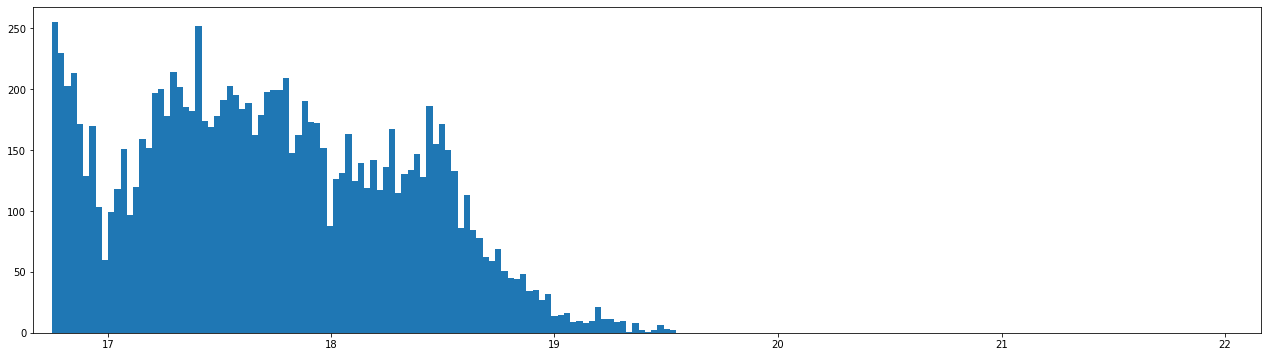

In [28]:
ride_data_Flex = ride_data.loc[ride_data['passholder_type'] == 'Flex Pass']
plt_date = mdates.date2num(ride_data_Flex['start_time'])
fig, ax = plt.subplots(1, figsize=(22,6))
n, bins, patches = plt.hist(plt_date, bins=100)
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%y'))
plt.xlim(mdates.datestr2num(['2016/09/01','2022/03/01']))
plt.show()

Esta opción con el tiempo probablemente fue descontinuada por falta de interés de los usuarios.

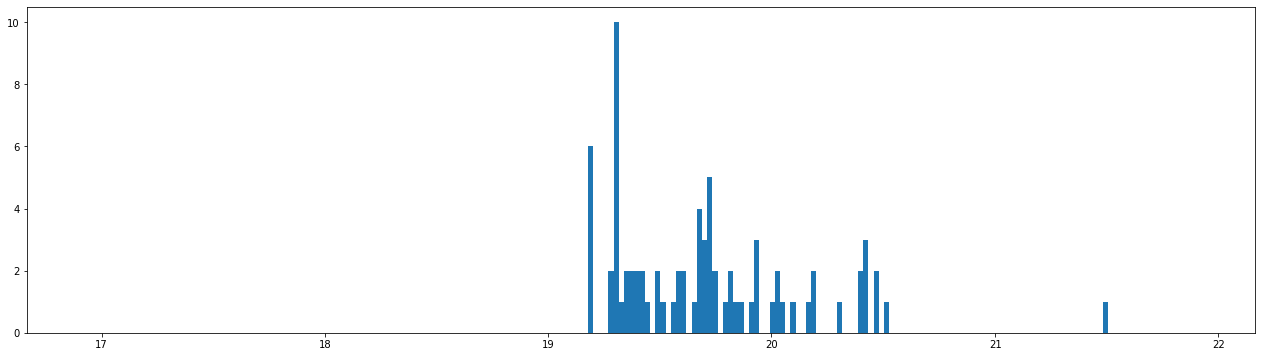

In [29]:
ride_data_Testing = ride_data.loc[ride_data['passholder_type'] == 'Testing']
plt_date = mdates.date2num(ride_data_Testing['start_time'])
fig, ax = plt.subplots(1, figsize=(22,6))
n, bins, patches = plt.hist(plt_date, bins=100)
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%y'))
plt.xlim(mdates.datestr2num(['2016/09/01','2022/03/01']))
plt.show()

Ahora exploremos como es el comportamiento en un día de servicio.

In [30]:
start_dates = ride_data['start_time'].copy()

De los datos extraemos solo las horas y minutos y las guardamos en un nuevo data frame

In [31]:
start_times = []
for dates in start_dates:
    time = dates.time()
    time_flt = time.hour+time.minute/60.0
    start_times.append([time_flt])
    
start_time = pd.DataFrame(start_times, columns=["start_time"])

Veamos como se distribuyen

array([[<AxesSubplot:title={'center':'start_time'}>]], dtype=object)

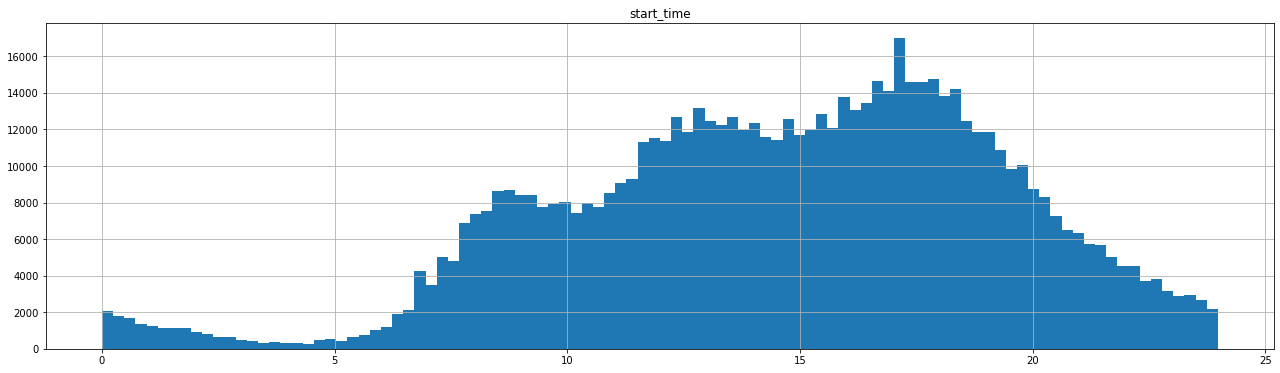

In [33]:
start_time.hist(bins=100, figsize=(22,6))

De estos datos se ve que el pico de uso está hacia la tarde.
Veamos como cambia este comportamiento según el tipo de usuario.

array([[<AxesSubplot:title={'center':'start_time'}>]], dtype=object)

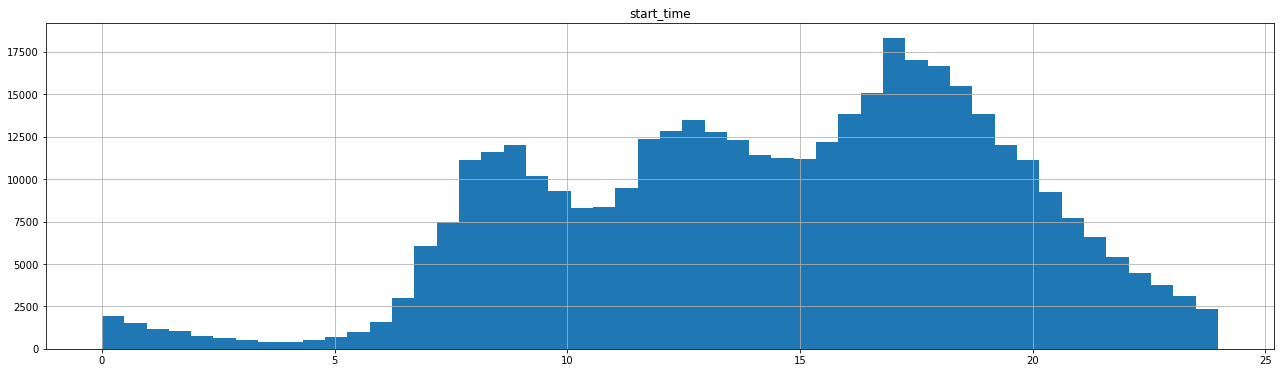

In [35]:
start_dates_Monthly = ride_data_Monthly['start_time'].copy()
start_times = []
for dates in start_dates_Monthly:
    time = dates.time()
    time_flt = time.hour+time.minute/60.0
    start_times.append([time_flt])
    
start_time_Monthly = pd.DataFrame(start_times, columns=["start_time"])
start_time_Monthly.hist(bins=50, figsize=(22,6))

array([[<AxesSubplot:title={'center':'start_time'}>]], dtype=object)

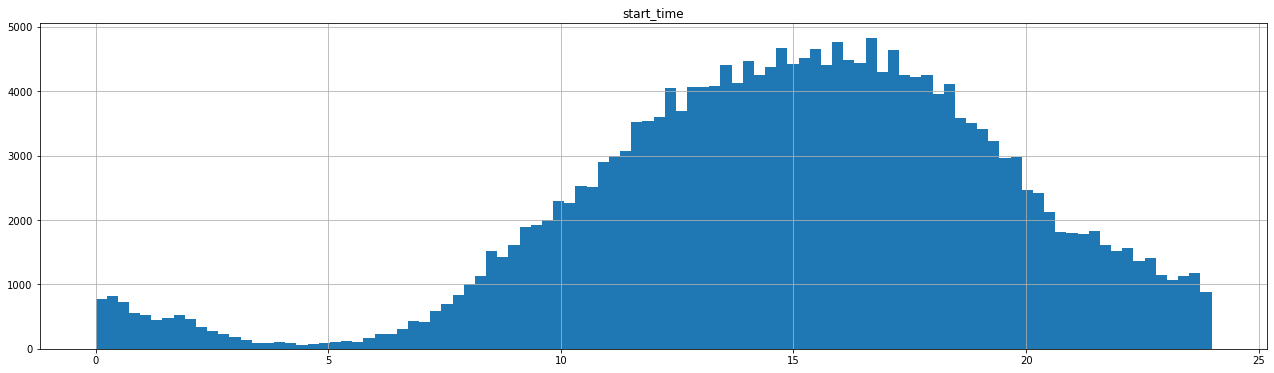

In [36]:
start_dates_Walk = ride_data_Walk['start_time'].copy()
start_times = []
for dates in start_dates_Walk:
    time = dates.time()
    time_flt = time.hour+time.minute/60.0
    start_times.append([time_flt])
    
start_time_Walk = pd.DataFrame(start_times, columns=["start_time"])
start_time_Walk.hist(bins=100, figsize=(22,6))

array([[<AxesSubplot:title={'center':'start_time'}>]], dtype=object)

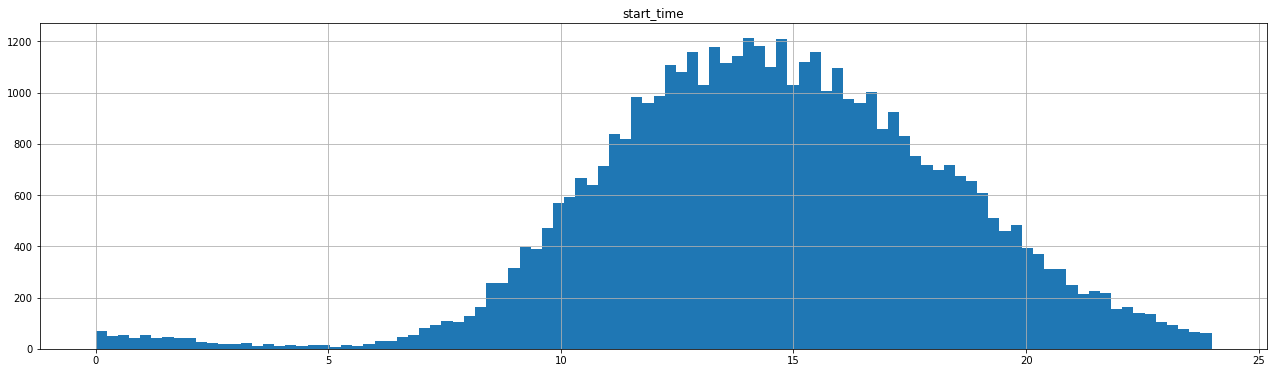

In [37]:
start_dates_One_Day = ride_data_One_Day['start_time'].copy()
start_times = []
for dates in start_dates_One_Day:
    time = dates.time()
    time_flt = time.hour+time.minute/60.0
    start_times.append([time_flt])
    
start_time_One_Day = pd.DataFrame(start_times, columns=["start_time"])
start_time_One_Day.hist(bins=100, figsize=(22,6))

array([[<AxesSubplot:title={'center':'start_time'}>]], dtype=object)

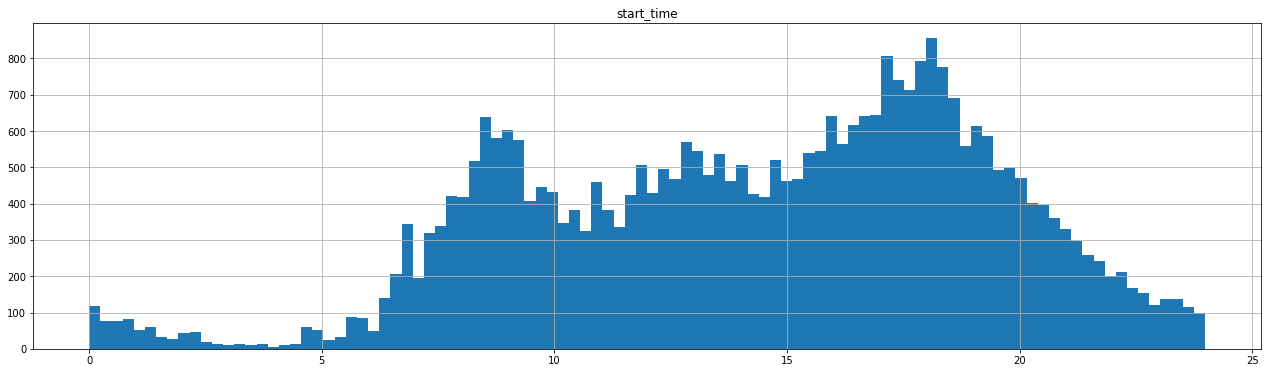

In [38]:
start_dates_Annual = ride_data_Annual['start_time'].copy()
start_times = []
for dates in start_dates_Annual:
    time = dates.time()
    time_flt = time.hour+time.minute/60.0
    start_times.append([time_flt])
    
start_time_Annual = pd.DataFrame(start_times, columns=["start_time"])
start_time_Annual.hist(bins=100, figsize=(22,6))

array([[<AxesSubplot:title={'center':'start_time'}>]], dtype=object)

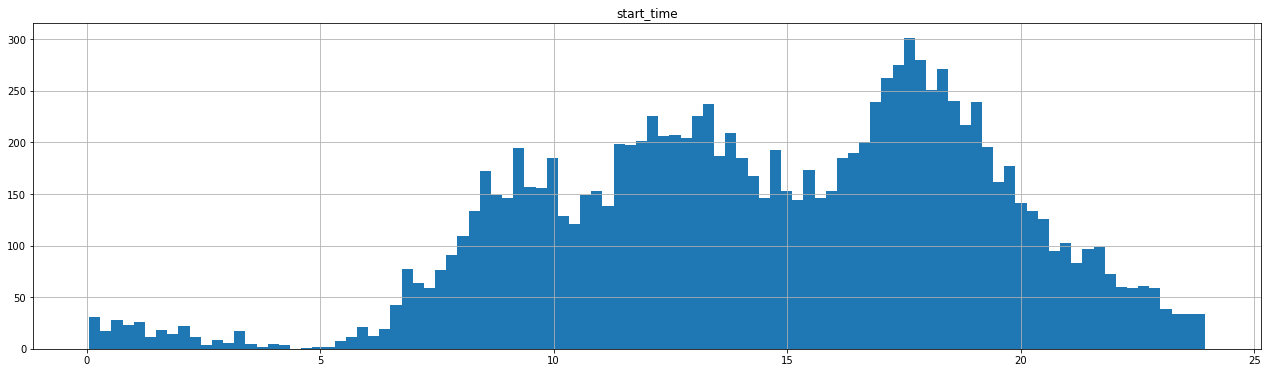

In [39]:
start_dates_Flex = ride_data_Flex['start_time'].copy()
start_times = []
for dates in start_dates_Flex:
    time = dates.time()
    time_flt = time.hour+time.minute/60.0
    start_times.append([time_flt])
    
start_time_Flex = pd.DataFrame(start_times, columns=["start_time"])
start_time_Flex.hist(bins=100, figsize=(22,6))